## In this first part, we define the benchmark functions we are going to use and create a function to plot any benckmark function that can be added in the future

In [3]:
import math
import random
import plotly.graph_objects as go
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def rosenbrock(x, y):
    a = 0
    b = 1
    return (a-x)**2 + b*(y-x**2)**2

def rastrigin(x, y):
    n = 2
    return 10*n + (x**2 - 10*np.cos(2*math.pi*x)) + (y**2 - 10*np.cos(2*np.pi*y))

def plot_function(function):

    # benchmark function settings
    xmin = -2
    xmax = -xmin

    ymin = -2
    ymax = -ymin

    # plot x, y axis value settings
    xs = np.arange(xmin, xmax, 0.25)
    ys = np.arange(ymin, ymax, 0.25)
    X, Y = np.meshgrid(xs, ys)

    Z = function(X, Y)

    fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])
    fig.update_layout(title = function.__name__.capitalize(),
                    width=500, 
                    height=500,
                    margin=dict(l=65, r=50, b=65, t=90))

    return fig

In [4]:
rast = plot_function(rastrigin)
rosen = plot_function(rosenbrock)

# Create subplots
fig = make_subplots(rows=1, 
                    cols=2, 
                    subplot_titles=['Rastrigin', 'Rosenbrock'],
                    specs=[[{'type': 'surface'}, {'type': 'surface'}]]
                    )

# Plotting benchmark functions
fig.add_trace(rast.data[0], row=1, col=1)
fig.add_trace(rosen.data[0], row=1, col=2)

fig.show()

## Now we create the class that receives any benchmark function and runs PSO over it to try to find it's global minimum

In [5]:
class PSO():
  def __init__(self, benchmark, ideal_target, error_threshold, 
               num_particles, return_frames, inertia_grad=True,
               a_const = 0.9, b_const= 2, c_const = 2):
    self.benchmark = benchmark
    self.a_const = a_const
    self.b_const = b_const
    self.c_const = c_const
    self.ideal_target = ideal_target
    self.error_threshold = error_threshold
    self.inertia_grad = inertia_grad
    self.num_particles = num_particles
    self.benchmark_recorder = np.array([])
    self.error_recorder = []
    self.frames = []
    self.return_frames = return_frames
    self.gbest_val = float('inf')
    self._create_particles()
    self._init_global_best_pos()

  def _create_particles(self):
    # 2D Array for best x and y
    self.particle_best_pos = np.zeros(shape=(self.num_particles, 2)) 
    self.particle_best_val = np.zeros(self.num_particles)
    self.particle_curr_pos = np.zeros(shape=(self.num_particles, 2))
    # initial velocity = 0
    self.particle_curr_velo = np.zeros(shape=(self.num_particles, 2)) 

    # Setting the initial params of the particles
    for ind_particle in range(self.num_particles):
      self.particle_curr_pos[ind_particle][0] = (-1)**(bool(random.getrandbits(1))) * \
                                                random.random()   # random start point x
      self.particle_curr_pos[ind_particle][1] = (-1)**(bool(random.getrandbits(1))) * \
                                                random.random()   # random start point y
      self.particle_best_pos[ind_particle][0] = self.particle_curr_pos[ind_particle][0]  # init best pos x = start pos x
      self.particle_best_pos[ind_particle][1] = self.particle_curr_pos[ind_particle][1]  # init best pos y = start pos y

  def _init_global_best_pos(self):
    # universally one in global topology, therefore just a 2d array required
    self.gbest_pos = np.zeros(2)    
    self.gbest_pos[0] = -1
    self.gbest_pos[1] = -1

  def pbest_setter(self):
    for particle in range(self.num_particles):
      benchmark_reward_candidate = self.benchmark(self.particle_curr_pos[particle][0], \
                                             self.particle_curr_pos[particle][1]) 
      if(self.particle_best_val[particle] > benchmark_reward_candidate):
        #update best value and corresponding position
        self.particle_best_val[particle] = benchmark_reward_candidate
        self.particle_best_pos[particle] = self.particle_curr_pos[particle]

  def gbest_setter(self):
    for particle in range(self.num_particles):
      benchmark_reward_candidate = self.benchmark(self.particle_curr_pos[particle][0], \
                                             self.particle_curr_pos[particle][1])
      if(self.gbest_val > benchmark_reward_candidate):
        self.gbest_val = benchmark_reward_candidate
        self.gbest_pos = self.particle_curr_pos[particle]

  def start_particle_motion(self):
    for particle in range(self.num_particles):
      new_velocity = (self.a_const * self.particle_curr_velo[particle]) \
                      + (self.b_const * random.random() * (self.particle_best_pos[particle] - self.particle_curr_pos[particle])) \
                      + (self.c_const * random.random() * (self.gbest_pos - self.particle_curr_pos[particle]))

      new_position = self.particle_curr_pos[particle] + new_velocity
      self.particle_curr_velo[particle] = new_velocity # update particle velocity
      self.particle_curr_pos[particle] = new_position  # update particle position
      self.benchmark_recorder = self.benchmark(self.particle_curr_pos[particle][0], \
                                                         self.particle_curr_pos[particle][1])

    # update frames list data
    self.frames.append([self.particle_curr_pos[:][0].copy(),
                          self.particle_curr_pos[:][1].copy(),
                          self.benchmark_recorder.copy()])
    
  def ps_optimizer(self, num_iterations):
    iter = 0
    while(iter < num_iterations):
      self.pbest_setter()
      self.gbest_setter()

      curr_error = self.ideal_target - self.gbest_val
    
      self.error_recorder.append(abs(curr_error))

      '''
      If the defined error threshold is acheived, return it.
      '''
      if (self.error_threshold >= abs(curr_error)):
        if self.return_frames:
            return self.frames
        
        return self.error_recorder
        break
      
      '''
      Parameter Optimization: 
      Here, we compare the results of a constant inertia 
      and time-varying inertia.
      SOTA for PSO paramtere optimzation states that
      inertia(a) should be gradually decreased from 0.9 to 0.4 over the defined
      iterations. The code below will start with a=0.9 and linearly reduce the 
      inertia parameter to 0.4
      '''
      if self.inertia_grad:
          self.a_const = 0.9 - (float(0.5)*(float(iter)/num_iterations))
      self.start_particle_motion()
      iter += 1

    if self.return_frames:
        return self.frames
    return self.error_recorder

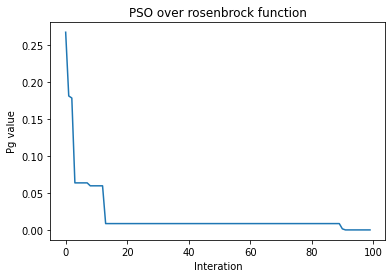

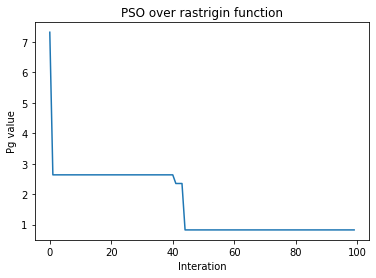

In [6]:
pso_rosenbrock = PSO(rosenbrock, 0, 0.00001, 10, return_frames=False).ps_optimizer(100)
pso_rastrigin = PSO(rastrigin, 0, 0.00001, 10, return_frames=False).ps_optimizer(100)

# Ploting PSO over rosenbrock
plt.plot(pso_rosenbrock)
plt.title('PSO over rosenbrock function')
plt.xlabel('Interation')
plt.ylabel('Pg value')
plt.show()

# Ploting PSO over rastrigin
plt.plot(pso_rastrigin)
plt.title('PSO over rastrigin function')
plt.xlabel('Interation')
plt.ylabel('Pg value')
plt.show()

## Experiment 1 - Parameter optimization of inertia 'a'

In [9]:
'''Function to run PSO with a fixed parameter a vs SOTA mentioned gradient a, 
   and return the distribution of the minimum values found'''
def compare_pso_fixed_vs_varied_inertia(function_name):

    final_pso_fixed_values = []
    final_pso_dec_values = []
    n_executions = 50
    for _ in tqdm(range(n_executions)):

        # Execute PSO with fixed a
        pso_history_fixed = PSO(function_name, 0, 0.00001, 10, return_frames=False, inertia_grad=False).ps_optimizer(100)
        final_pso_fixed_values.append(pso_history_fixed[-1])

        # Execute PSO with linearly decreasing a
        pso_history_dec = PSO(function_name, 0, 0.00001, 10, return_frames=False, inertia_grad=True).ps_optimizer(100)
        final_pso_dec_values.append(pso_history_dec[-1])

    return final_pso_fixed_values, final_pso_dec_values

In [11]:
# Function to plot the comparison of PSO w.r.t inertia given a benchmark function
def plot_pso_inertia_comparison(function_name):

    final_pso_fixed_values, final_pso_dec_values = compare_pso_fixed_vs_varied_inertia(function_name)

    sns.kdeplot(final_pso_fixed_values)
    plt.axvline(np.mean(final_pso_fixed_values), ls='--', c='r');
    plt.xlabel('Pg')
    plt.title('PSO fixed inertia distribution after 50 executions')
    plt.show()

    sns.kdeplot(final_pso_dec_values)
    plt.axvline(np.mean(final_pso_dec_values), ls='--', c='r');
    plt.xlabel('Pg')
    plt.title('PSO gradient inertia distribution after 50 executions')
    plt.show();

## Observation 1 - 
By running PSO ~50 times on both the benchmarks, we compare the difference in results obtained over a fixed inertia(a) and a variable inertia(as mentioned in SOTA) - linearly decreased from a=0.9 to a=0.4 over the iterations and conclude that SOTA observations were indeed correct as we have a lower standard deviation with variable inertia.

100%|██████████| 50/50 [00:01<00:00, 29.68it/s]


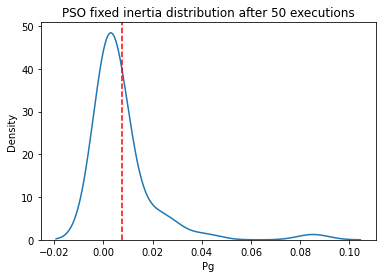

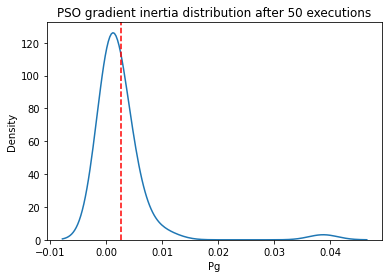

In [12]:
'''for rosenbrock benchmark'''
plot_pso_inertia_comparison(rosenbrock)

100%|██████████| 50/50 [00:02<00:00, 18.46it/s]


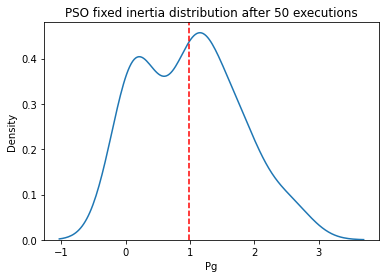

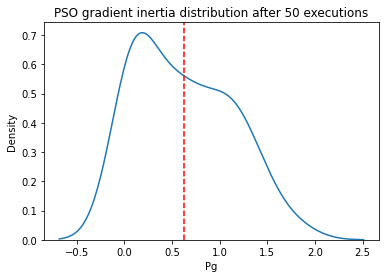

In [13]:
'''for rastrigin benchmark'''
plot_pso_inertia_comparison(rastrigin)

## Experiment 2 - Observing error trend against increasing number of particles

In [44]:
def compare_error_against_particle_num(function_name):
    pso_error_values = []
    particle_num_list = []
    init_num = 10
    max_num = 100
    curr_num = init_num
    for _ in (range(init_num, max_num, 10)):        
        pso_history_fixed = PSO(function_name, 0, 0.00001, curr_num, return_frames=False, inertia_grad=True).ps_optimizer(100)
        particle_num_list.append(curr_num)
        pso_error_values.append(pso_history_fixed[-1])
        curr_num += 10
    return pso_error_values, particle_num_list

In [63]:
# Function to plot the comparison of PSO w.r.t inertia given a benchmark function
def plot_pso_error_vs_num(function_name):

    pso_error_values, particle_num_list = compare_error_against_particle_num(function_name)
    
    sns.lineplot(x=particle_num_list, y=pso_error_values)
    plt.xlabel('Num particles')
    plt.ylabel('Error')
    plt.title('PSO particles number vs Error')
    plt.show()

## Observation 2 - 
As the number of particles increase, the error decreases upto ~50 particles, then starts increasing again

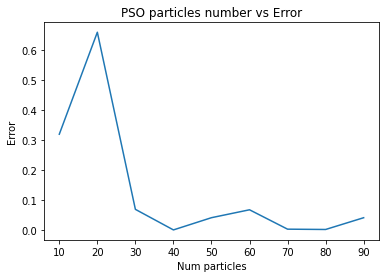

In [70]:
plot_pso_error_vs_num(rastrigin)

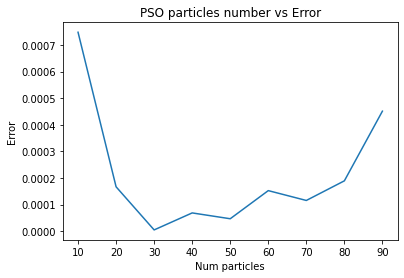

In [71]:
plot_pso_error_vs_num(rosenbrock)

# Implementing Gradient Descent 

In [9]:
import math
import random
import numpy as np

_rosenbrock = lambda x,y,a,b: (a - x) ** 2 + b * (y - x ** 2) ** 2

gradient_rosenbrock = lambda x, y, a, b: np.asarray([(-2 * a + 4 * b * x ** 3 - 4 * b * x * y + 2 * x), 2 * b * (y - x ** 2)])

gradient_rastrigin = lambda x, y: np.asarray([(2 * (x + 10 * math.pi * math.sin(2 * math.pi * x))), (2 * (y + 10 * math.pi * math.sin(2 * math.pi * y)))])

_rastrigin = lambda x, y: 10*2 + (x**2 - 10*np.cos(2*math.pi*x)) + (y**2 - 10*np.cos(2*np.pi*y))

def dzdx_ronsenbrock(x, y):
    # I have got something else here any idea why?
    a = 0
    return -2*a + 2*x - 4*y*x + 4*x**3

# Rosenbrock's derivative over y
def dzdy_ronsenbrock(x, y):
    b = 1
    return 2*b*y - 2*x**2

# Rastrigin's derivative over x
def dzdx_rastrigin(x):
    return 2*x - 20*math.pi*math.sin(2*math.pi*x)

# Rastrigin's derivative over y
def dzdy_rastrigin(y):
    return 2*y - 20*math.pi*math.sin(2*math.pi*y)

# Function to apply GD over functions
#def rastrigin(x, y):
#    pass


def gradient_descent(function_name):

    stepSize = 0.01
    x = random.uniform(-2, 2)
    y = random.uniform(-2, 2)

    # for rosenbrock only:
    a = 0
    b = 1
    if function_name == 'rosenbrock':
           history = [np.asarray([x,y,_rosenbrock(x, y, a, b)])]
    else:
        history = [np.asarray([x,y,_rastrigin(x, y)])]
    pos = [x,y]
    max_iter = 100
    for _ in range(max_iter):
        if function_name == 'rosenbrock':
            pos = pos - stepSize * gradient_rosenbrock(pos[0],pos[1], a, b)
            z = _rosenbrock(pos[0], pos[1], a, b)
        elif function_name == 'rastrigin':
            pos = pos - stepSize * gradient_rastrigin(pos[0],pos[1])
            z = _rastrigin(pos[0], pos[1])
        else:
            raise Exception('function_name must be rosenbrock or rastrigin')
        history.append(np.asarray([pos[0],pos[1],z]))
    return np.asarray(history)

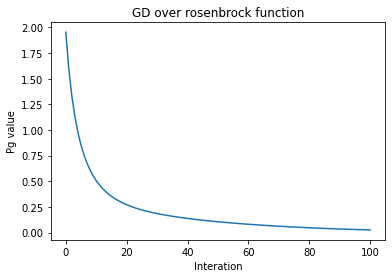

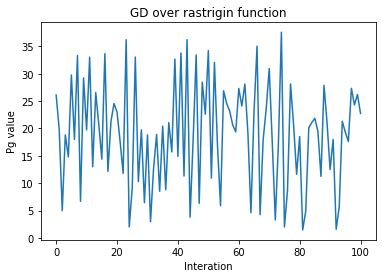

In [10]:
# Ploting GD over rosenbrock
zs = gradient_descent('rosenbrock')[:,2]
plt.plot(zs)
plt.title('GD over rosenbrock function')
plt.xlabel('Interation')
plt.ylabel('Pg value')
plt.show();

# Ploting GD over rastrigin
zs = gradient_descent('rastrigin')[:,2]
plt.plot(zs)
plt.title('GD over rastrigin function')
plt.xlabel('Interation')
plt.ylabel('Pg value')
plt.show();

## Experiment 3 - Comparing PSO and Gradient Descent on given benchmarks

In [11]:
# Function to run PSO and GD many times over a function, and return the distribution of the minimum values found
def compare_pso_and_gd_for_benchmark_function(function_name):

    final_pso_values = []
    final_gradient_descent_values = []
    n_executions = 50
    for _ in tqdm(range(n_executions)):

        # Execute PSO
        pso_history = PSO(function_name, 0, 0.00001, 20, return_frames=False).ps_optimizer(100)
        final_pso_values.append(pso_history[-1])

        # Execute gradient descent
        gd_history = gradient_descent(function_name.__name__)[:,2]
        final_gradient_descent_values.append(gd_history[-1])

    return final_pso_values, final_gradient_descent_values

In [12]:
# Function to plot the comparison of GD and PSO given a benchmark function
def plot_pso_gd_comparison(function_name):

    final_pso_values, final_gradient_descent_values = compare_pso_and_gd_for_benchmark_function(function_name)

    sns.kdeplot(final_pso_values)
    plt.axvline(np.mean(final_pso_values), ls='--', c='r');
    plt.xlabel('Pg')
    plt.title('PSO final values distribution after 50 executions')
    plt.show()

    sns.kdeplot(final_gradient_descent_values)
    plt.axvline(np.mean(final_gradient_descent_values), ls='--', c='r');
    plt.xlabel('Pg')
    plt.title('GD final values distribution after 50 executions')
    plt.show();

## Observation 3 - 
After running the PSO and GD algorithms many times over the Rastrigin's function, we see that PSO is much more effective in finding the global minimum, dispite that it's performance over Rastringin is worse than it's own performance over Rosenbrock's function, due to the more complex nature of the function.

100%|██████████| 50/50 [00:01<00:00, 30.55it/s]


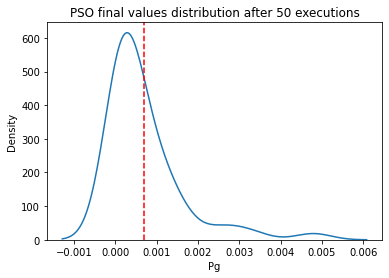

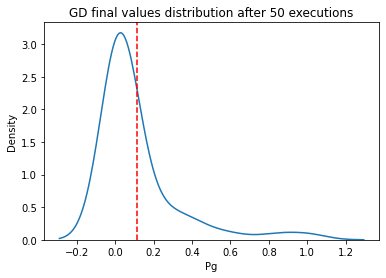

In [13]:
# Rosenbrock comparison between PSO and GD
plot_pso_gd_comparison(rosenbrock)

## Observation 4 -
GD performs very poorly over Rastringin's function, due to the high number of local minimas presented.

100%|██████████| 50/50 [00:02<00:00, 18.06it/s]


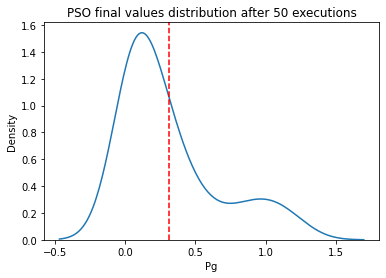

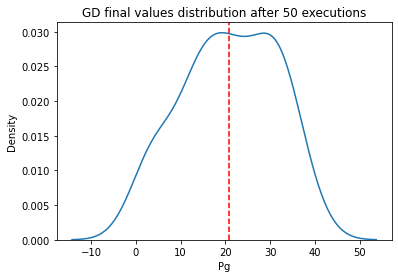

In [14]:
# Rastringin comparison between PSO and GD
plot_pso_gd_comparison(rastrigin)

## Visualization methods - 

In [7]:
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
from IPython.core.display import HTML
from matplotlib import cm
    
def update(i, data, graph):
    graph._offsets3d = (data[i][0], data[i][1], data[i][2])
    graph.axes.view_init(azim=2*i)
    # ax.view_init(azim=angle)

def generate_visualization(data, function, save=True, alpha=0.5, file_name='animation'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs = np.arange(-2, 2, 0.25)
    ys = np.arange(-2, 2, 0.25)
    X, Y = np.meshgrid(xs, ys)

    Z = function(X, Y)

    ax.plot_surface(X, Y, Z, alpha=alpha, cmap=cm.magma)
    graph = ax.scatter(data[0][0], data[0][1], data[0][2], c='black', s=10, alpha=0.7)


    # Number of iterations
    iterations = len(data)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Animated Scatter Example')
    ax.view_init(25, 10)

    fps = 10
    ani = animation.FuncAnimation(fig, 
                                  update, 
                                  iterations,
                                  fargs=(data, graph),
                                  interval=1000/fps)

    if save:
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=fps, 
                        extra_args=['-vcodec', 'libx264'])
        ani.save(f'{file_name}.mp4', writer=writer)

    return ani

In [16]:
%pip install ffmpeg-python

Note: you may need to restart the kernel to use updated packages.


In [12]:
frames = PSO(rosenbrock, 0, 0.00001, 2, return_frames=True).ps_optimizer(2)

print(frames)
#print(np.asarray(frames).shape)
#ani = generate_visualization(np.array(frames), rastrigin, alpha=0.3, file_name='RastriginPSO');

#HTML(ani.to_html5_video())

[[array([0.04645223, 0.61931851]), array([-0.10943391, -0.08086714]), 0.020595587624014085], [array([-0.18072713, -0.4010912 ]), array([-0.19206404, -0.4520126 ]), 0.2759129710580759]]


Number of frames: 5
Dimension of each frame: 3


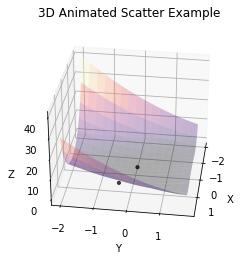

In [22]:
frames = PSO(rosenbrock, 0, 0.00001, 10, return_frames=True).ps_optimizer(5)
ani = generate_visualization(np.array(frames), rosenbrock, alpha=0.3, file_name='RastriginPSO');

print("Number of frames: " + str(len(frames)))
print("Dimension of each frame: " + str(len(frames[4])))

print(frames[0])

plt.show()
#HTML(ani.to_html5_video())

(101, 3)


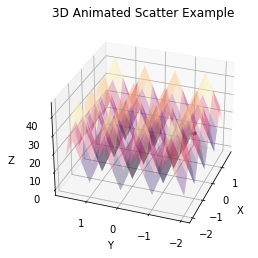

In [19]:
frames = gradient_descent('rastrigin')
print(frames.shape)
ani = generate_visualization(frames.reshape((101, 3,1)), rastrigin, alpha=0.3, file_name='RastriginGD');

HTML(ani.to_html5_video())

(101, 3)


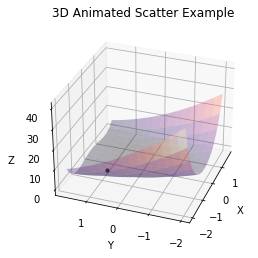

In [20]:
frames = gradient_descent('rosenbrock')
print(frames.shape)
ani = generate_visualization(frames.reshape((101, 3,1)), rosenbrock, alpha=0.3, file_name='RosenbrockGD');

HTML(ani.to_html5_video())

## Discussion on when to use DS together with PSO

PSO is an algorithm that searches randomly through a space. GD is an algorithm that uses information about the surface's inclination (gradient) to find its next step towards the minimum.

If applying gradient information to the PSO algorithm, that might contribute to the exploitation fase to converge faster.

In short, PSO can help in the phase of exploration, and GD can help on the phase of exploitation.

Paper: https://www.sciencedirect.com/science/article/abs/pii/S1568494611003206
